## Stock Performance Tracker


## Setup


In [1]:
import pandas as pd

import const
import draw_utils
import process_utils

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# plt.style.use("fivethirtyeight")


In [3]:
log_df, cf_df = process_utils.prepare_log_df_cf_df(
    acc_user_dict=const.ACC_USER_DICT,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_name_l=const.INDEX_NAME_L,
    index_combined_name=const.INDEX_COMBINED_NAME,
)


## [Chart] Index over time


/Users/kaestrl/projects/python/stock_tracker/draw_utils.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(


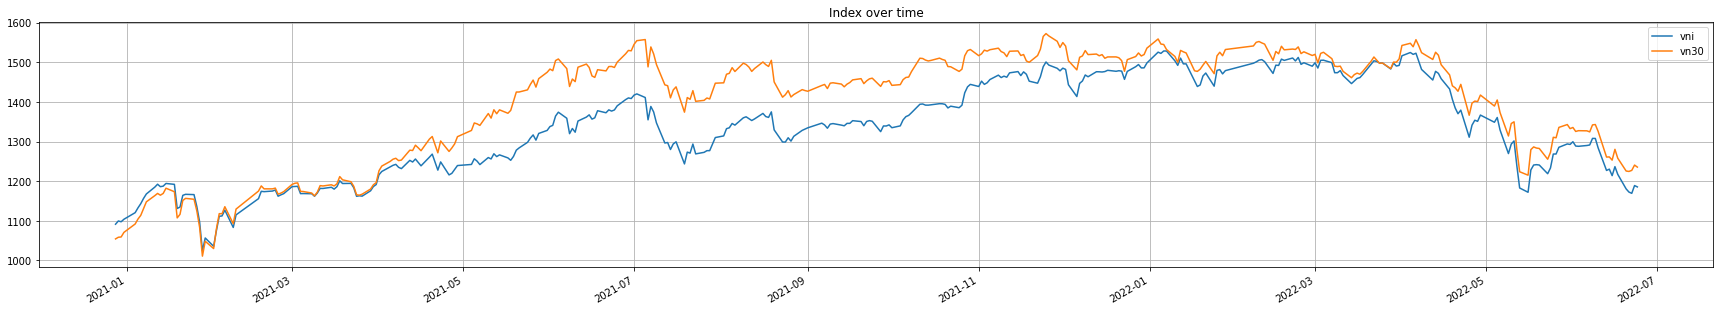

In [4]:
index_values_dict = {
    index_name: list(log_df[index_name]) for index_name in const.INDEX_NAME_L
}
draw_utils.plot_indices_over_time(
    time_series=list(log_df.index),
    index_values_dict=index_values_dict,
)


In [5]:
const.INDEX_NAME_L

['vni', 'vn30']

## [Chart] NAV stack


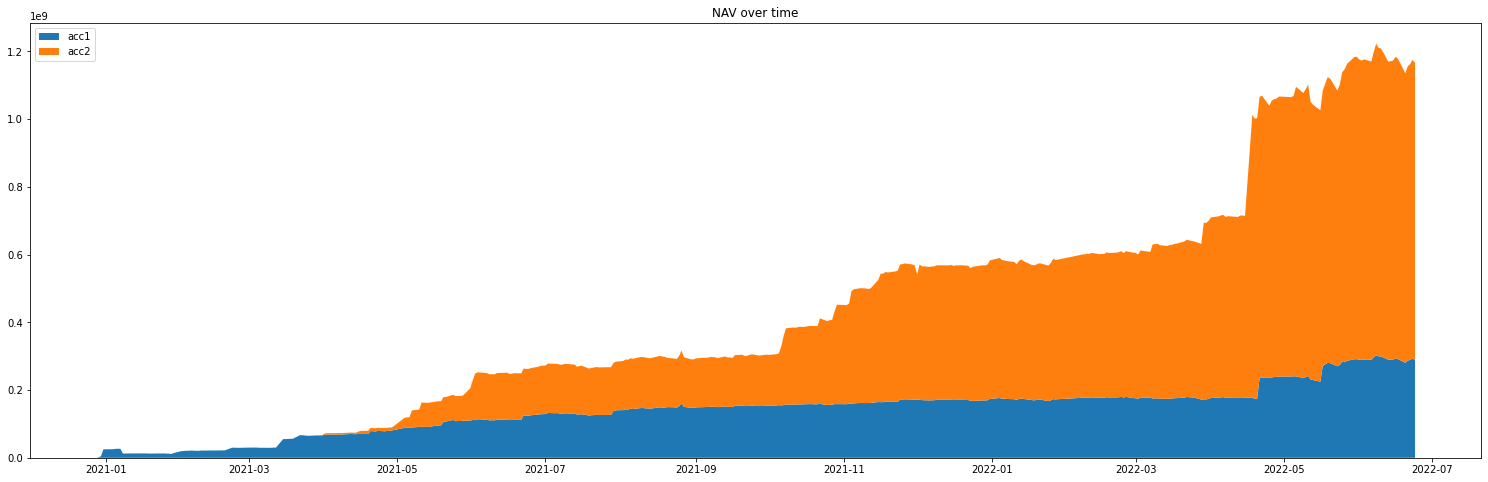

In [6]:
y_list = [log_df[acc_name] for acc_name in const.ACC_NAME_L]

draw_utils.plot_nav_stackplot(
    x=log_df.index,  # type: ignore
    y=y_list,
    labels=const.ACC_NAME_L,
)


## [Chart] NAV pie


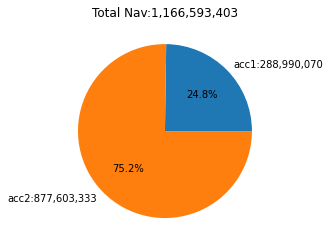

In [7]:
nav_l = [log_df[acc_name].iloc[-1] for acc_name in const.ACC_NAME_L]  # type: ignore
label_l = [f"{acc_name}:{nav:,}" for acc_name, nav in zip(const.ACC_NAME_L, nav_l)]
draw_utils.plot_nav_pie(nav_l, label_l=label_l)


## [Chart] Profit


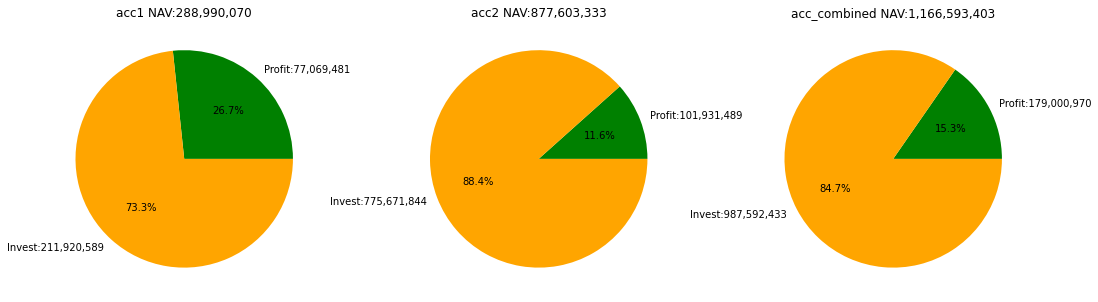

In [8]:
profit_invest_list: list[tuple[str, float, float]] = []
for name in const.ALL_ACC_NAME_L:
    nav = log_df[name].iloc[-1]
    invest = -cf_df[name].sum()
    profit = nav - invest
    profit_invest_list.append((name, profit, invest))

draw_utils.plot_profit_invest_pies(profit_invest_list)


## [Chart] Diff percent


### Histogram


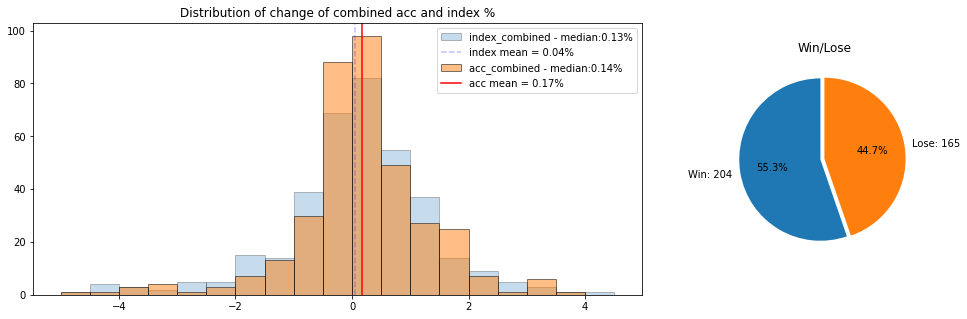

In [9]:
draw_utils.plot_daily_diff_p_distribution(
    log_df,
    acc_name=const.ACC_COMBINED_NAME,
    index_name=const.INDEX_COMBINED_NAME,
)


## [Chart] Daily


### Latest growth


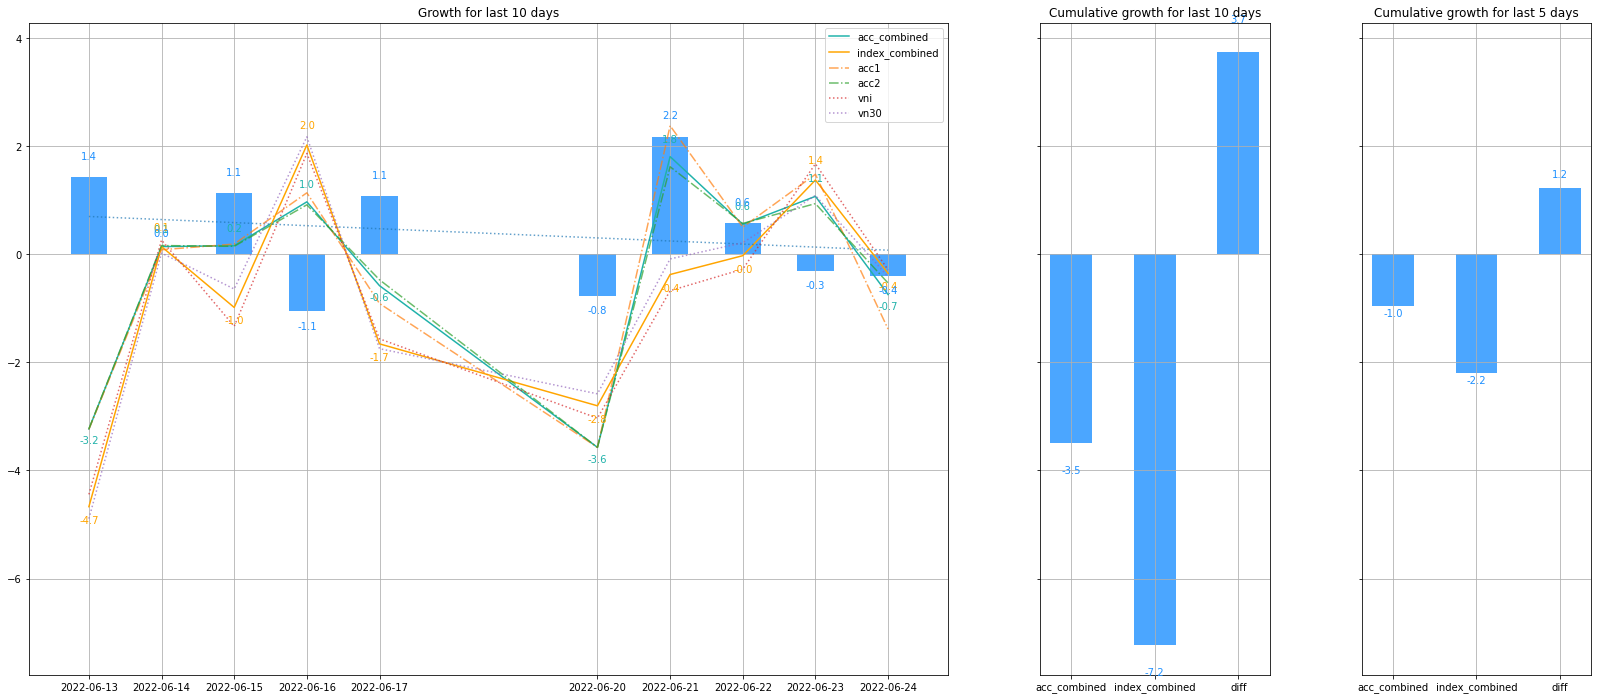

In [10]:
draw_utils.plot_recent_growth(
    log_df,
    num_days=10,
    main_acc_name=const.ACC_COMBINED_NAME,
    main_index_name=const.INDEX_COMBINED_NAME,
    secondary_acc_name_l=const.ACC_NAME_L,
    secondary_index_name_l=const.INDEX_NAME_L,
)


### XIRR


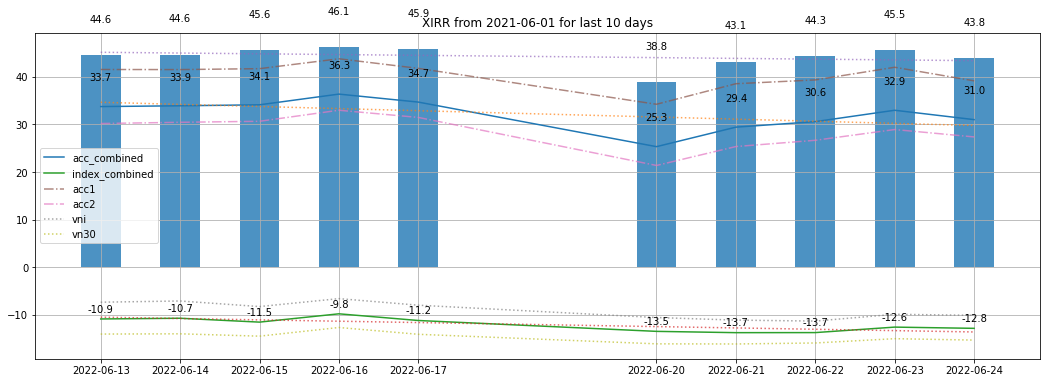

In [11]:
draw_utils.plot_recent_xirr(
    log_df=log_df,
    cf_df=cf_df,
    num_days=10,
    anchor_date='2021-06-01',
    main_acc_name=const.ACC_COMBINED_NAME,
    main_index_name=const.INDEX_COMBINED_NAME,
    secondary_acc_name_l=const.ACC_NAME_L,
    secondary_index_name_l=const.INDEX_NAME_L,
)

### Income


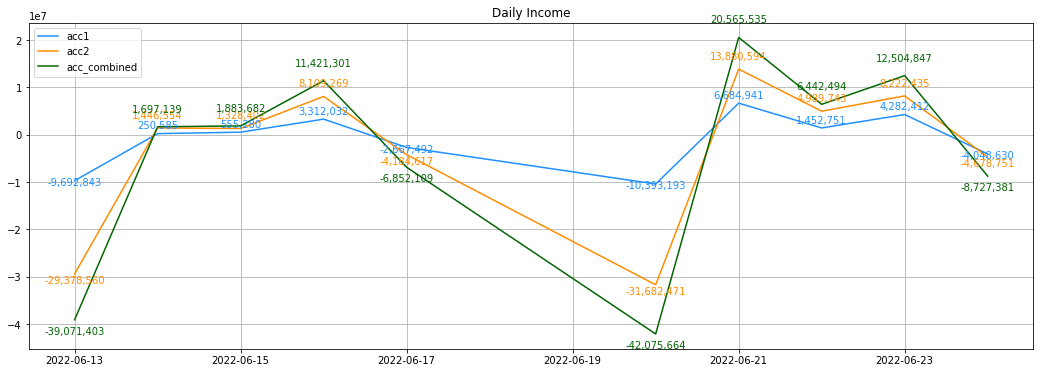

In [12]:
draw_utils.plot_recent_income(
    daily_df=log_df,
    num_days=10,
    name_l=const.ALL_ACC_NAME_L,
)


### Growth time series


In [13]:
anchor_date = "2022-1-1"

growth_xirr_df = process_utils.get_overall_growth_xirr_df(
    log_df,
    cf_df,
    anchor_date=anchor_date,
    acc_name_l=const.ALL_ACC_NAME_L,
    index_name_l=const.ALL_INDEX_NAME_L,
)


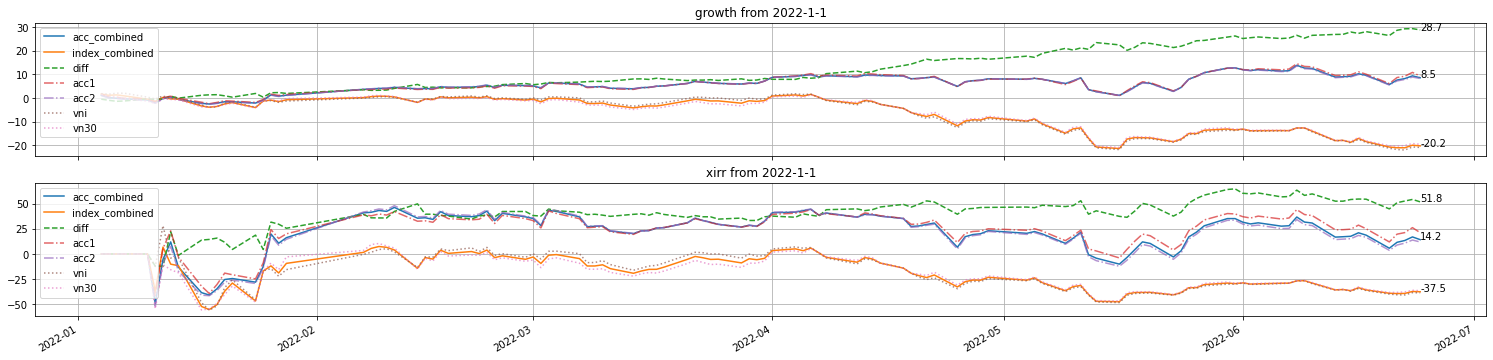

In [14]:
draw_utils.plot_growth_xirr_over_time(
    growth_xirr_df,
    anchor_date=anchor_date,
    main_acc_name=const.ACC_COMBINED_NAME,
    main_index_name=const.INDEX_COMBINED_NAME,
    secondary_acc_name_l=const.ACC_NAME_L,
    secondary_index_name_l=const.INDEX_NAME_L,
)


## [Process] Add period info


In [15]:
log_df = process_utils.add_period_cols(log_df)
# log_df.tail()


## [Chart] Weekly


In [16]:
weekly_df = process_utils.get_period_df(
    period_symbol="W",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Not enough space to plot every week
weekly_df = process_utils.filter_latest_x_rows(df=weekly_df, row_num=20)  # type: ignore


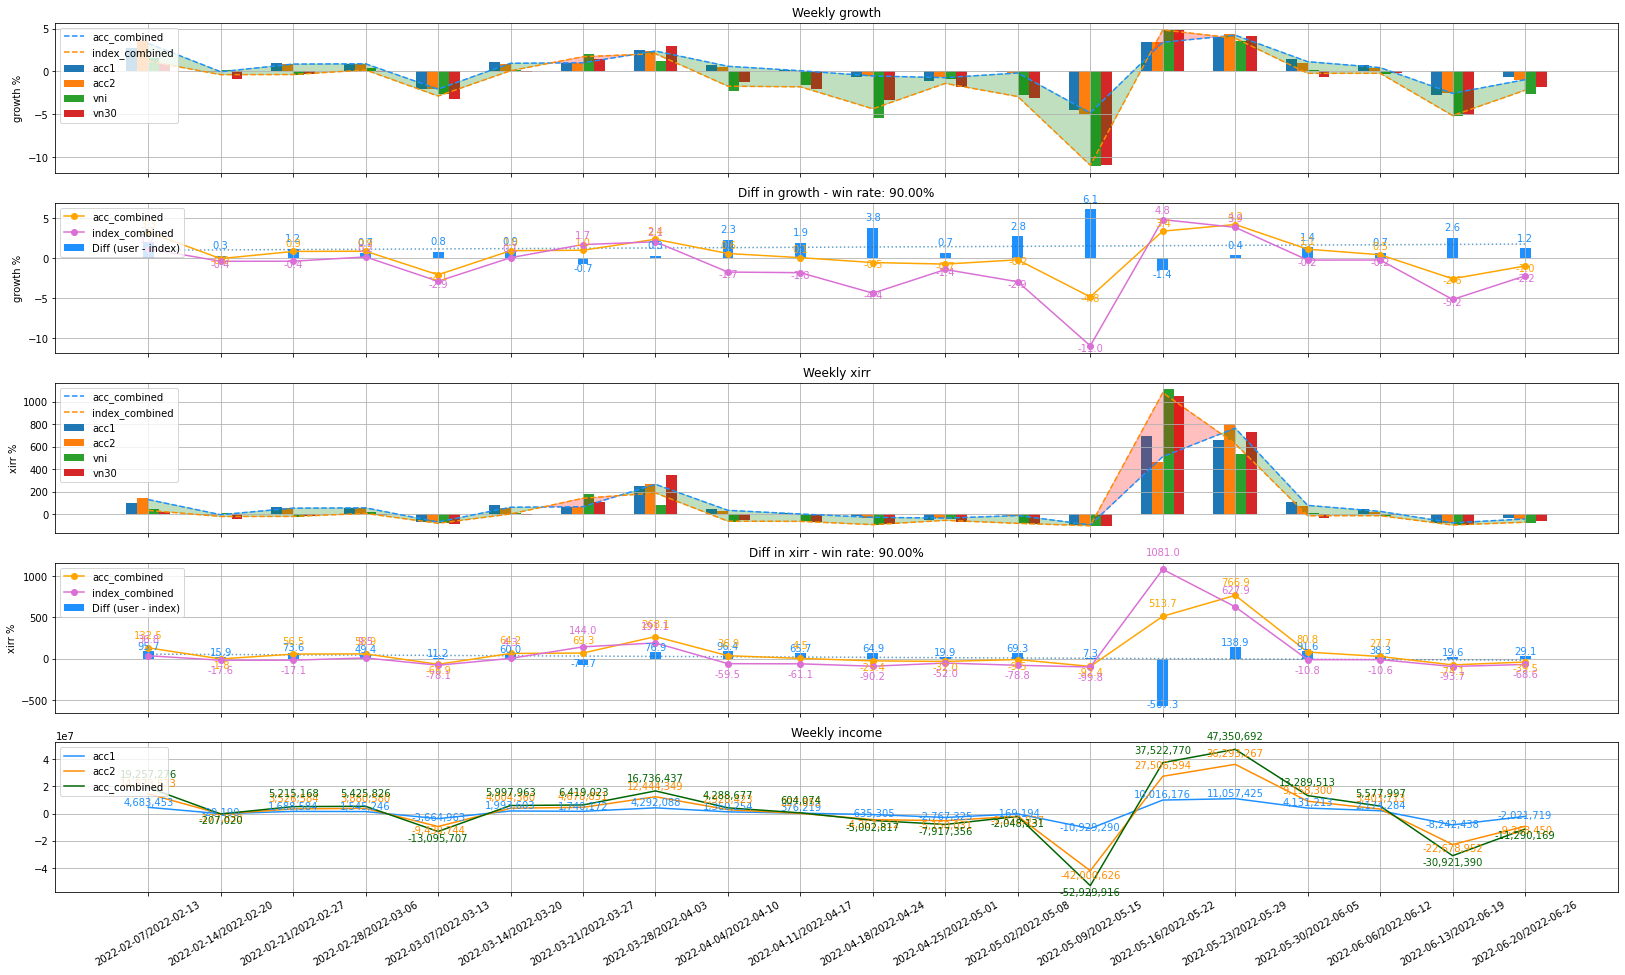

In [17]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=weekly_df,
    period_name="Weekly",
    main_acc_name=const.ACC_COMBINED_NAME,
    main_index_name=const.INDEX_COMBINED_NAME,
    secondary_acc_name_l=const.ACC_NAME_L,
    secondary_index_name_l=const.INDEX_NAME_L,
    income_acc_name_l=const.ALL_ACC_NAME_L,
)


## [Chart] Monthly


In [18]:
monthly_df = process_utils.get_period_df(
    period_symbol="M",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020-12
monthly_df.drop(["2020-12"], inplace=True)


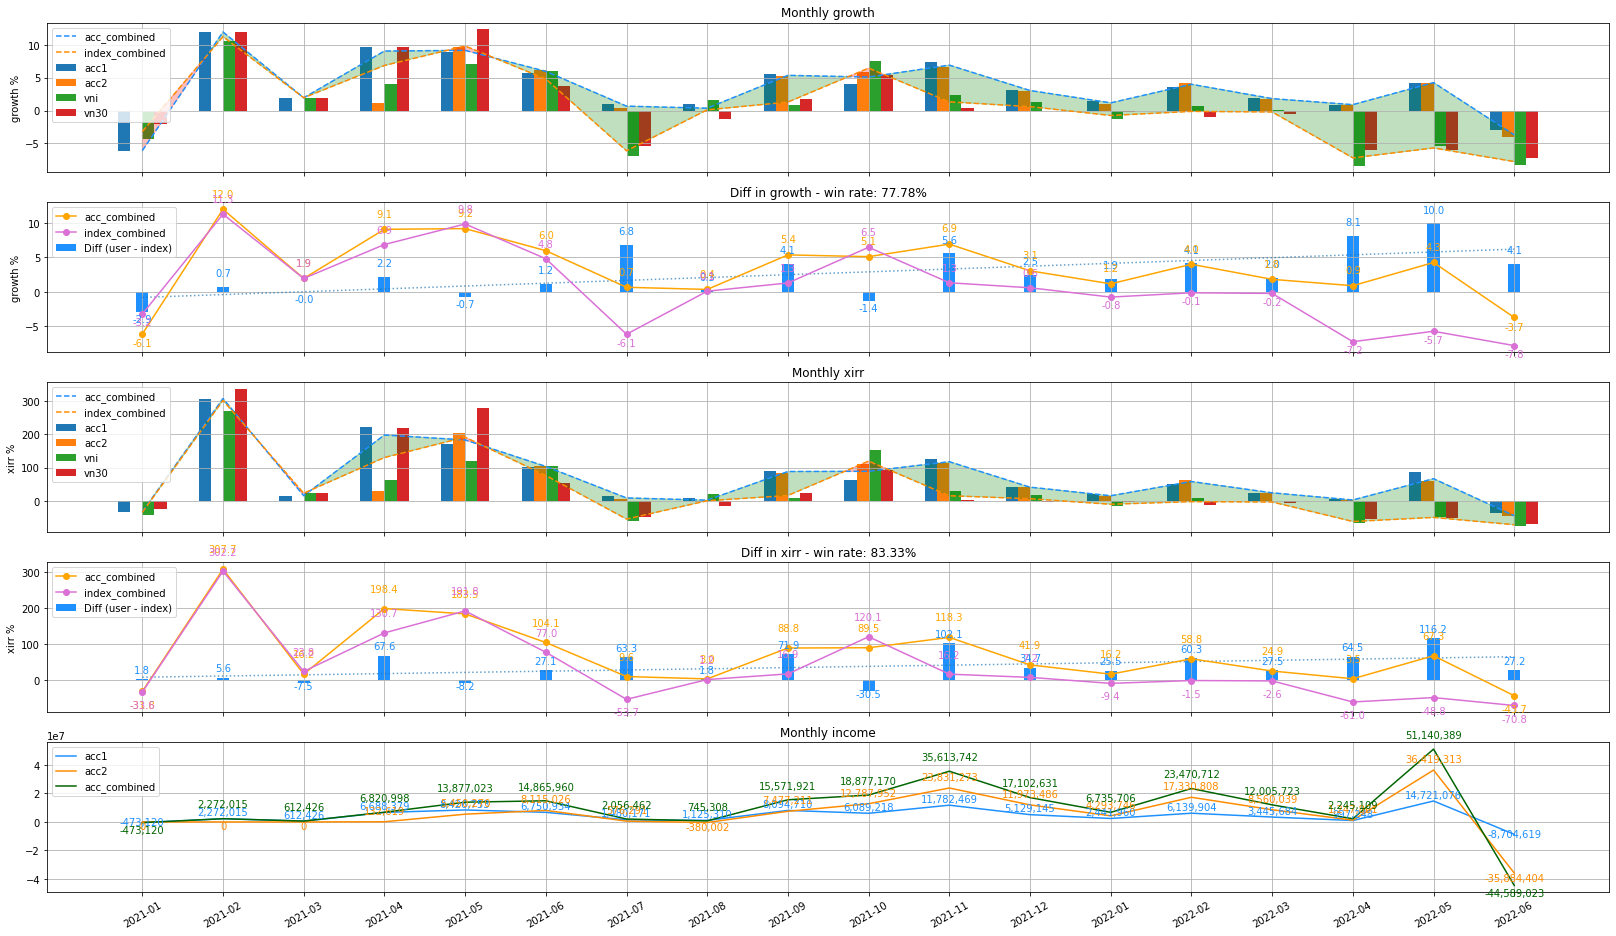

In [19]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=monthly_df,
    period_name="Monthly",
    main_acc_name=const.ACC_COMBINED_NAME,
    main_index_name=const.INDEX_COMBINED_NAME,
    secondary_acc_name_l=const.ACC_NAME_L,
    secondary_index_name_l=const.INDEX_NAME_L,
    income_acc_name_l=const.ALL_ACC_NAME_L,
)


## Quaterly


In [20]:
quaterly_df = process_utils.get_period_df(
    period_symbol="Q",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020Q4
quaterly_df.drop(["2020Q4"], inplace=True)


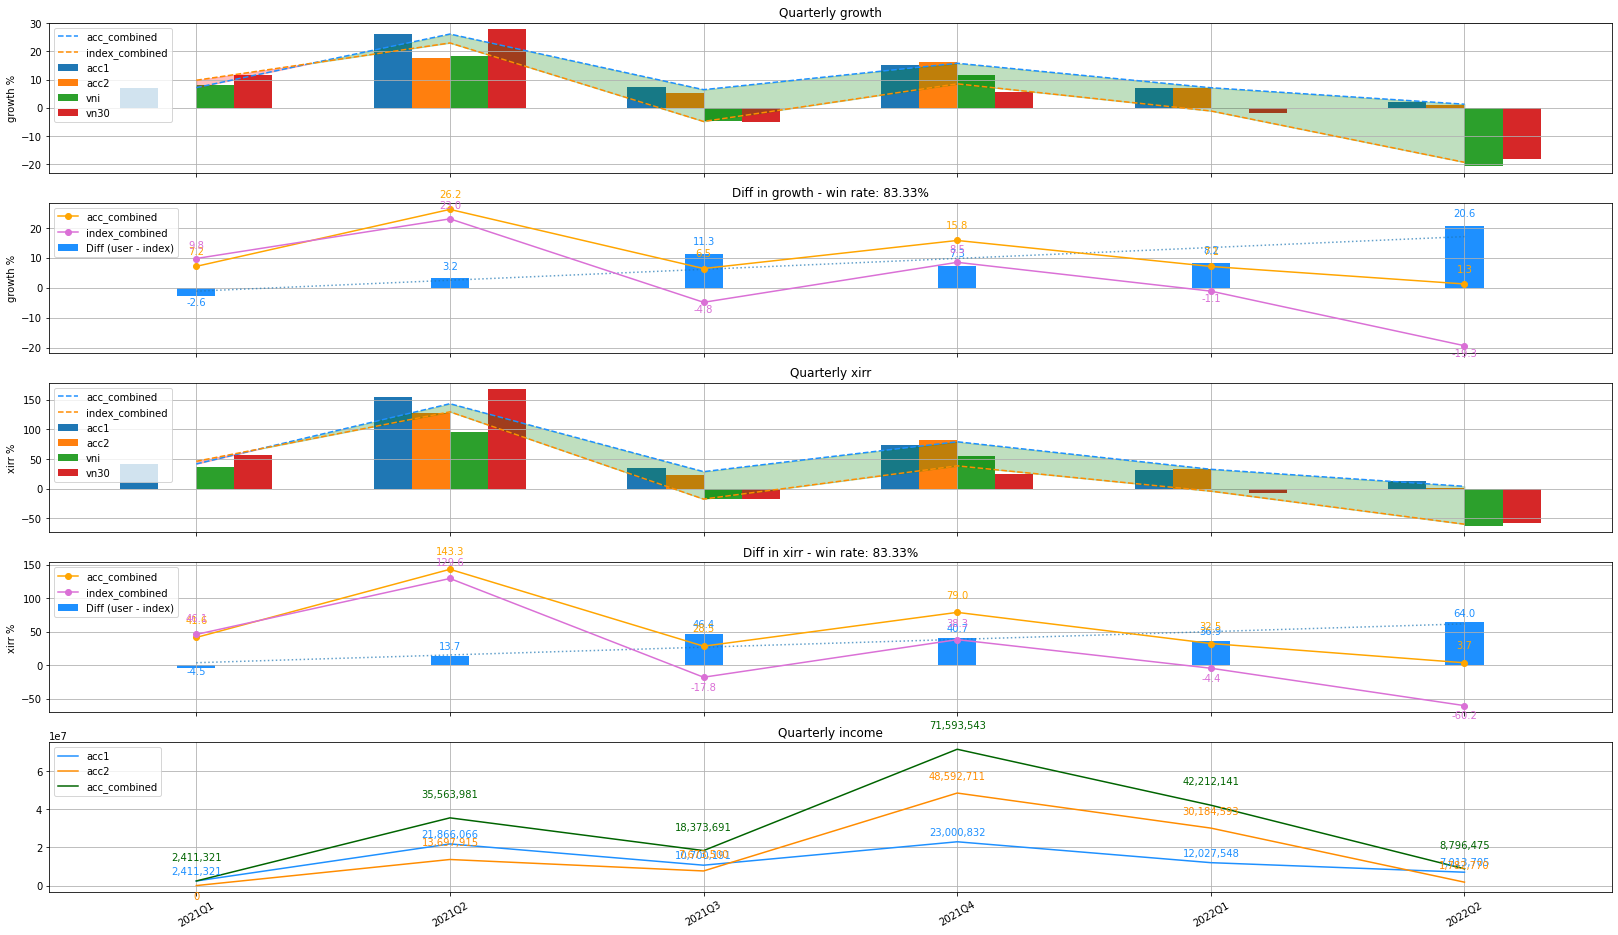

In [21]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=quaterly_df,
    period_name="Quarterly",
    main_acc_name=const.ACC_COMBINED_NAME,
    main_index_name=const.INDEX_COMBINED_NAME,
    secondary_acc_name_l=const.ACC_NAME_L,
    secondary_index_name_l=const.INDEX_NAME_L,
    income_acc_name_l=const.ALL_ACC_NAME_L,
)


## Yearly


In [22]:
yearly_df = process_utils.get_period_df(
    period_symbol="Y",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020
yearly_df.drop(["2020"], inplace=True)


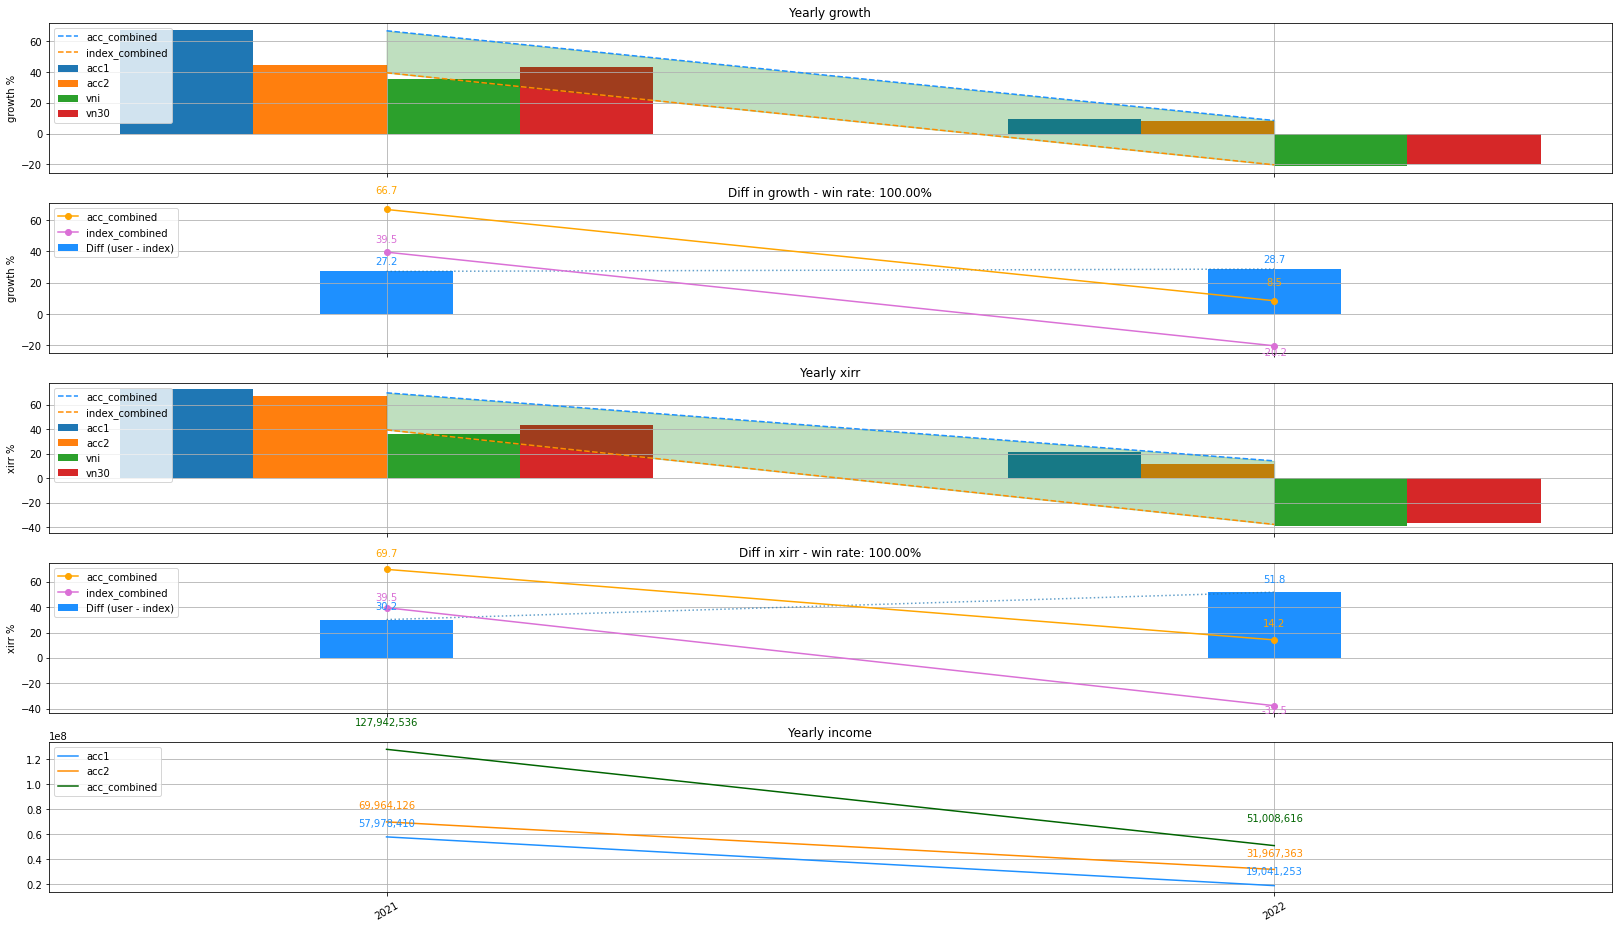

In [23]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=yearly_df,
    period_name="Yearly",
    main_acc_name=const.ACC_COMBINED_NAME,
    main_index_name=const.INDEX_COMBINED_NAME,
    secondary_acc_name_l=const.ACC_NAME_L,
    secondary_index_name_l=const.INDEX_NAME_L,
    income_acc_name_l=const.ALL_ACC_NAME_L,
)
